<a href="https://colab.research.google.com/github/sejhig2/Project_mask_healthy/blob/main/test_gun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 준비하기

## 1.1 데이터 준비하기



### 1.1.1 데이터셋 다운 받기
roboflow

https://public.roboflow.com/

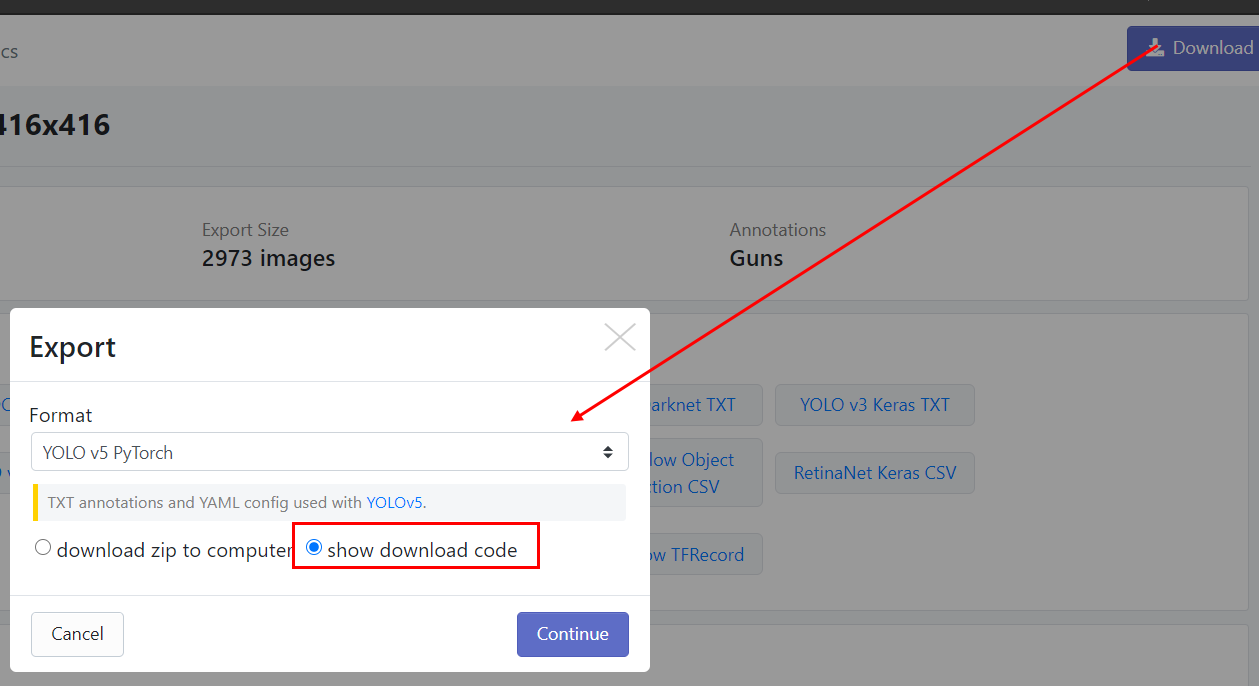


### 코드로 가져온 데이터셋을 코랩으로 불러오기
옵션 3가지 중에jupyternotebook에 맞게 가져온다.

In [ ]:
!curl -L "https://public.roboflow.com/ds/JhqXMwCJ88?key=lK30O5Brxr" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

코랩의 왼쪽 트리를 보면 export 안에 이미지와 레이블이 들어온 것을 확인할 수 있다.

###1.2 yolo 설치
1. 디렉토리를 바꿔줄 것이다 (현재 폴더에서 yolo를 사용해줄 것이기 때문에)
2. github에서 clone 해서 받을 것이다( !git clone 깃허브주소 )

In [ ]:
%cd /content
!git clone https://github.com/ultralytics/yolov5.git

3. yolo 디렉토리로 이동 후 yolo 설치하기

In [ ]:
%cd /content/yolov5/
!pip install -r requirements.txt

- 가져다 쓸 파일을 좀 편하게 가져다 쓰기 위해서 폴더를 하나 만들어서 몰아 넣어주자.
    1. dataset 폴더 만들기
    2. export 폴더 통째로 dataset 폴더로 이동
    3. READEME.dataset.txt , READEME.roboflow.txt, data.yaml 파일 3개 dataset폴더로 이동

### 1.3 데이터셋 전처리
1. data.yaml 이 무엇인지 확인

    train 경로와, 검증(val) 경로, 클래스(총이라는 것)을 알 수 있다.

In [ ]:
%cat /content/dataset/data.yaml

2. 이미지를 모두 가져오고 장 수를 확인한다.
-   [glob](https://wikidocs.net/83)모듈 설명

In [ ]:
%cd /

# 모든 이미지를 가져온다.
from glob import glob
img_list = glob("/content/dataset/export/images/*.jpg")

print("가져온 이미지의 총 수 : ",len(img_list))

3. 훈련 데이터가 나눠져 있지 않다. 훈련데이터 -> 훈련, 검증 데이터로 나누자

In [ ]:
from sklearn.model_selection import train_test_split

train_img_list, val_img_list = train_test_split( img_list, test_size = 0.2 , random_state=2000 )

print("훈련 데이터의 수 : ",len(train_img_list),"검증 데이터의 수 :",len(val_img_list) )

4. 트레이닝 이미지 경로, 검증(validation) 이미지 경로를 txt파일로 저장해두자

In [ ]:
with open('/content/dataset/train.txt','w') as f:
    f.write('\n'.join(train_img_list)+'\n')
with open('/content/dataset/val.txt','w') as f:
    f.write('\n'.join(val_img_list) +'\n')

2. 

### 1.4 yaml 파일 수정하기
불러온 yolo의 data.yaml 파일에 train 정보와 val의 정보가 한 파일에 다 들어있다. 나눠서 사용해야한다.
- yaml 패키지 import
- data.yaml 읽어오기
- train 과 val 나눠서 할당 

In [ ]:
import yaml

with open("/content/dataset/data.yaml", 'r') as f :
    data = yaml.load(f)

print(data)

data['train'] = '/content/dataset/train.txt'
data['val'] = '/content/dataset/val.txt'

with open("/content/dataset/data.yaml", 'w') as f :
    yaml.dump(data, f )

print(data)

- 경로가 바뀌었다.
원래 : 'train': '../train/images'

- 바꾼 후 : 'train': '/content/dataset/train.txt'

# 훈련하기
- 훈련에 대한 함수의 자세한 사용법은  [yolo github](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data)에서 볼 수 있다.  
링크타고 들어가서 5절의 train에 가서 보면 된다.
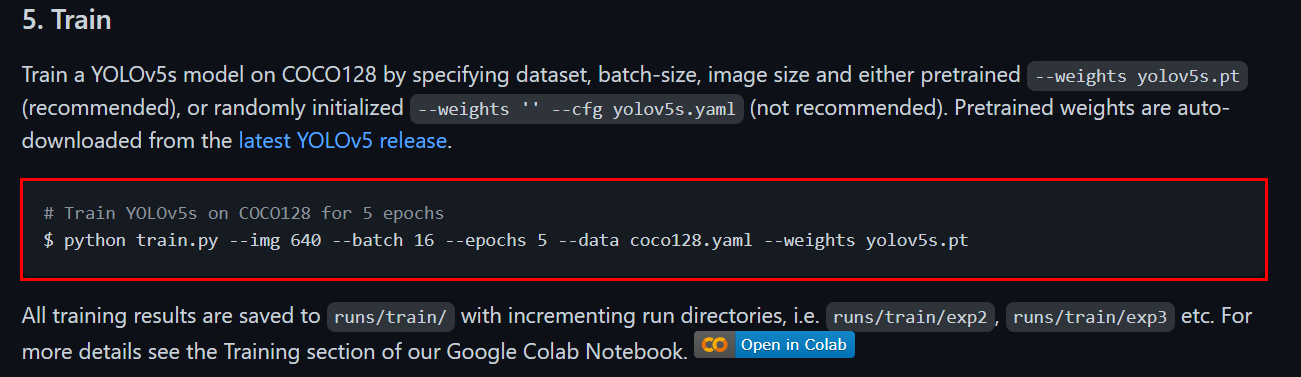

- 훈련
img 크기는 : 416

batch : 16

epoch : 50 

data : 내 경로에 맞게 data.yaml 파일

cfg : 모델의 구조를 나타낸다 ( yolov5 -> models -> yolov5 s,m,l,x 사이즈가 있다. 크기의 차이는 yolo model의 속도 차이인듯 하다)

--weights yolov5s.pt :  훈련돼있는 weights를 사용할거라서 불러온 것

--name gun_yolov5s_results : 모델 이름을 지정해준 것

In [ ]:
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 50 --data /content/dataset/data.yaml --cfg ./models/yolov5s.yaml --weights yolov5s.pt --name gun_yolov5s_results

- 훈련한 내용을 tensorboard 를 통해 시각적으로 보자

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/yolov5/runs/

# 테스트 하기

## 3.1 검증 데이터를 가져와서 테스트한다.

3.1.1 검증 데이터에서 사진 하나를 가져와서(여기서는 경로만) 

3.1.2 내가 훈련시킨 모델에 적용하자. 훈련시킨 모델을 yolov5/runs/에 들어있다.

3.1.3 파이썬의 detect파일을 열고 하이퍼파라미터가 들어있는 weights 도 가져온다. 모델은 best모델로 가져오자

In [ ]:
print(val_img_list[1])

In [ ]:
from IPython.display import Image
import os
val_img_path = val_img_list[2]
!python detect.py --weights /content/yolov5/runs/train/gun_yolov5s_results/weights/best.pt --img 416 --conf 0.5 --source "{val_img_path}"
Image(os.path.join('/content/yolov5/inference/ouuput', os.path.basename(val_img_path)))